<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/02_neural_network_cancer_survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

import tensorflow
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import metrics

# **Descripcion**
---



Utilizando el conjunto de datos de supervivencia de cancer se plicara cross validation, Wrapper, Optimización de hiperparametros

# **Objetivo**
---
Predecir pacientes con más posibilidades de morir.


# **Dicionario de datos**
---
Conjunto de datos de supervivencia de Haberman

- `Age`: Edad del paciente en el momento de la operación 
- `Year`: Año de operación del paciente 
- `Nodes`: Número de ganglios axilares positivos detectados
- `status`: Estado de supervivencia
-- 1  paciente sobrevivió 5 años o más
-- 2  paciente murió dentro de los 5 años


# **Data**
---



In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv', header=None, names=['age', 'year', 'node', 'status'])
data.head(5)

,age,year,node,status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     306 non-null    int64
 1   year    306 non-null    int64
 2   node    306 non-null    int64
 3   status  306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


- Todas las variables son de tipo numerico
- No hay valores nulos

In [4]:
data['status'].replace({1:0}, inplace=True)
data['status'].replace({2:1}, inplace=True)

# **Split**
---

In [5]:
data_values = data.values
X = data_values[:, :3]
y = data_values[:,3]

In [6]:
def plot_bars(data: np.ndarray, title: str= 'feature', x_size:int=6, y_size:int=4, font_size:int=15, x_label:str='churm',y_label:str='count', c_n_churm = '0', c_churm = '1')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(f'Count plot {title}', fontsize = font_size)
  sns.countplot(x = data, ax = ax)
  _, data_target = np.unique(data, return_counts=True)
  len_data = data.shape[0]
  pe = '{0:.2f}'.format(data_target[1]/len_data)
  ps = '{0:.2f}'.format(data_target[0]/len_data)
  ax.set_xticklabels([f'{c_n_churm} \n {ps}', f'{c_churm} \n{pe}'])
  ax.set(xlabel=x_label, ylabel=y_label)
  fig.show()

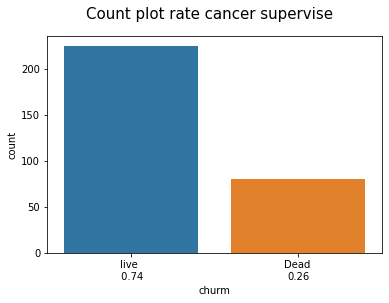

In [7]:
plot_bars(y, title = 'rate cancer supervise', c_churm='Dead', c_n_churm='live')

Hay un serio desbalance en el conjunto de datos del 74% registros son para los pacientes que vivieron y 26% son los pacientes que murireron.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1234, shuffle=True, stratify=y)

- Como las categorías se encuentran desbalanceadas, se procede a realizar una partición estratificada.

# **Model**
---

## **Model Base**
---

In [9]:
def model_base():
  model = Sequential()
  model.add(Dense(10, input_dim = 3, activation='relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(1,  activation='sigmoid', kernel_initializer='glorot_uniform'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [10]:
model = model_base()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 200, batch_size=5, verbose = 0)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


# **Curvas de aprendizaje de optimización model base**
---

In [12]:
def optimization_learning_curves(history: keras.callbacks.History, metrica, title: str= '', x_size:int=8, y_size:int=4, font_size:int=15, x_label:str='Epoch',y_label:str='Loss')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(title, fontsize = font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(x_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper left', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()

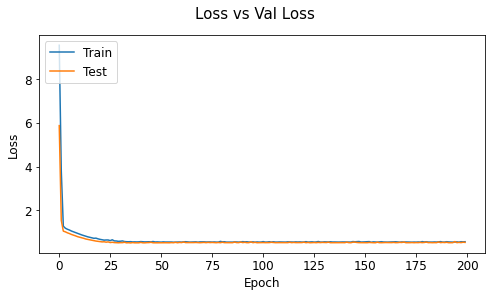

In [13]:
optimization_learning_curves(history, metrica='loss', title='Loss vs Val Loss')

La perdida de entrenamiento y validación disminuyen hasta el punto de estabilida durante 300 epocas, con una brecha de generailización casi inperceptible.

# **Prediction**
---

In [14]:
y_pred = (model.predict(X_test)>0.5).astype('int32')
y_pred = np.reshape(y_pred, y_pred.shape[0])
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [15]:
def consufion_matrix(validation: np.ndarray, prediction:np.ndarray, churm:str='churm', no_churm:str='no_churm',  title: str= 'Matriz de confusion', x_size:int=6, y_size:int=5)->np.ndarray:
  matrix = metrics.confusion_matrix(validation, prediction)
  fig, ax = plt.subplots(nrows= 1, ncols=  1, figsize = (x_size,y_size))
  sns.heatmap(matrix, annot=True, ax = ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size': 13})
  ax.set_title(title, size = 13)
  ax.xaxis.set_ticklabels([no_churm, churm])
  ax.yaxis.set_ticklabels([no_churm, churm])
  ax.tick_params(labelsize = 13)
  fig.show()
  return matrix

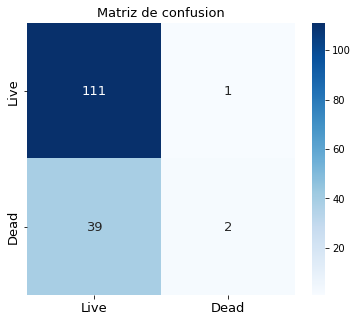

In [16]:
matrix = consufion_matrix(y_test, y_pred,'Dead', 'Live')

- A partir de la matriz, el modelo tiene problemas para  detectar pacientes con posibilidades de morir en 5 años, ya que hay pocos verdaderos positivos.

In [17]:
# Metricas
def metricas(validation: np.ndarray, prediction:np.ndarray, matrix:np.ndarray, label:list=[1], label_title:str='Target')->None:
  print(f'Accuracy  :   {metrics.accuracy_score(validation, prediction)}')
  print(f'Kappa     :   {metrics.cohen_kappa_score(validation, prediction)}')
  print(f'predicción {label_title}')
  print(f'Precision:   {metrics.precision_score(validation, prediction, labels=label, average="macro")}')
  print(f'Recall    :   {metrics.recall_score(validation, prediction, labels=label, average="macro")}')

  VN = matrix[0,0]
  FP = matrix[0,1]
  specificity = VN/(VN+FP)

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {metrics.f1_score(validation, prediction, labels=label, average="macro")}' )

In [18]:
metricas(y_test, y_pred, matrix, label_title='probabilidad de morir en 5 años')

Accuracy  :   0.738562091503268
Kappa     :   0.05642923219241436
predicción probabilidad de morir en 5 años
Precision:   0.6666666666666666
Recall    :   0.04878048780487805
Specificity:   0.9910714285714286
F1-score   :   0.0909090909090909


- La sensibilidad es pesima, el conjunto de datos es muy pequeño el modelo no es el indicado, cabe resaltar que no se ha tratado la red, ya que la idea es experimentar con datos.

In [19]:
y_prob = model.predict(X_test)
pos_prob = np.reshape(y_prob, y_prob.shape[0])

In [20]:
def precision_recall(y:np.ndarray, prediction_prob:np.ndarray, validation:np.ndarray)->float:
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  precision, recall, _ = metrics.precision_recall_curve(validation, prediction_prob)
  plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  auc_score = metrics.auc(recall, precision)
  plt.show()
  return auc_score

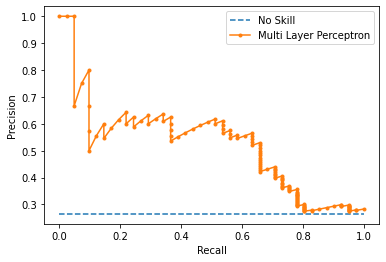

In [21]:
auc_score = precision_recall(y, pos_prob, y_test)

In [22]:
print('Multi Layer Perceptron PR AUC: %.3f' % auc_score)

Multi Layer Perceptron PR AUC: 0.524


- Acorde al area bajo la curva entre la precisión y la sensibilidad es pesimo no superando el modelo **sin habilidad**
- Es posible que con más datos y una estructura más amplia el modelo pueda mejorar su capacidad de predicción para detectar pacientes con diabetes.
- No se ha estandarizado los datos, puede que tambien influya .

# **Cross Validation**
---

In [23]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

cv_score_loss_train = []
cv_score_loss_test = []
cv_score_accuracy_train = []
cv_score_accuracy_test = []

for train, test in kfold.split(X, y):
  model = model_base()
  history = model.fit(X[train], y[train], validation_data=(X[test], y[test]), batch_size=5, epochs=200, verbose = 0)
  loss_train, accuracy_train = model.evaluate(X[train], y[train], verbose=0)
  loss_test, accuracy_test = model.evaluate(X[test], y[test], verbose=0)
  cv_score_loss_train.append(loss_train)
  cv_score_loss_test.append(loss_test)
  cv_score_accuracy_train.append(accuracy_train)
  cv_score_accuracy_test.append(accuracy_test)
  print('======================================================================')
  print('loss: %.3f accuracy: %.3f val loss: %.3f val accuracy: %.3f' % (loss_train * 100, accuracy_train * 100, loss_test * 100, accuracy_test * 100))



loss: 53.227 accuracy: 74.182 val loss: 51.199 val accuracy: 80.645
loss: 49.570 accuracy: 77.818 val loss: 50.389 val accuracy: 70.968
loss: 55.351 accuracy: 74.909 val loss: 51.923 val accuracy: 74.194
loss: 53.253 accuracy: 74.545 val loss: 57.103 val accuracy: 70.968
loss: 51.380 accuracy: 76.000 val loss: 54.139 val accuracy: 74.194
loss: 54.574 accuracy: 75.636 val loss: 62.657 val accuracy: 67.742
loss: 53.579 accuracy: 75.000 val loss: 64.261 val accuracy: 66.667
loss: 58.123 accuracy: 72.101 val loss: 45.569 val accuracy: 80.000
loss: 53.136 accuracy: 75.362 val loss: 51.309 val accuracy: 76.667
loss: 49.857 accuracy: 78.261 val loss: 63.205 val accuracy: 66.667


- Los valores de pérdida de entrenamiento y validación tienden a converger, pese a que el valor no es baja.
- Pese a que la metrica de exactitud (accuracy) no es la más indicada se ve que los valores de entrenamiento y validación también tiende a converger
- El modelo tiene un comportamiento que le permite generalizar ante datos no vistos.



In [24]:
print('============================== 10 Pliegues ==============================')
print('============================== Loss Train ==============================')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_score_loss_train)*100, np.std(cv_score_loss_train)*100))
print('============================== Loss Test ==============================')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_score_loss_test)*100, np.std(cv_score_loss_test)*100))
print('============================== Accuracy Train ==============================')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_score_accuracy_train), np.std(cv_score_accuracy_train)))
print('============================== Accuracy Test ==============================')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_score_accuracy_test), np.std(cv_score_accuracy_test)))

============================== 10 Pliegues ==============================
============================== Loss Train ==============================
53.21% (+/- 2.42%)
============================== Loss Test ==============================
55.18% (+/- 6.04%)
============================== Accuracy Train ==============================
0.75% (+/- 0.02%)
============================== Accuracy Test ==============================
0.73% (+/- 0.05%)


- La dispersión en la medida de la perdida tanto en entrenamiento, como en validación no se ven afectado por ruido estadistico es demasiado bajo, es confiable, pese a que la perdida tiene un valor que si bien no es alto, tampoco es bajo. Ademas de evidenciar que el modelo no tiende a un sobreajuste.

- Pese a que la medida de rendimiento seleccionada por motivos de aprendizaje mios, no es **la más indicada, puesto que el conjunto de datos se encuentran desbalanceado**, pero tiene un rendimiento convergente y similar tanto en entrenamiento como validación.

- El modelo bajo la metrica de optimización y rendimiento seleccionadas, no se considera un modelo excelente para detectar la diabete, es necesario mirar que otras tecnia se pueden aplicar.


# **Wrapper**
---

In [25]:
def model_optimizer(optimizer = 'rmsprop', init = 'glorot_uniform'):
  model = Sequential()
  model.add(Dense(10, input_dim = 3, activation='relu', kernel_initializer=init))
  model.add(Dense(1,  activation='sigmoid', kernel_initializer=init))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [26]:
model = KerasClassifier(build_fn=model_optimizer, epochs = 200, batch_size = 5, verbose = 0)

kfold = StratifiedKFold(n_splits=10, shuffle=True)
result = cross_val_score(model, X, y, cv = kfold)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


- Los resultados no parecen ser tan alejados los unos de los otros, el modelo tiende a converger, poco ruido, pero no es el más indicado para la detección de cancer o falta más datos.

In [27]:
result.mean()*100, result.std()*100

(74.18279528617859, 4.248182921850625)

- La media es confiable, ya que la **dispersión no es tán prolongada**.


# **Optimización de hiperparametros**
---

In [28]:
model_optimizer = KerasClassifier(build_fn=model_optimizer, verbose = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [29]:
optimizer = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform', 'he_normal']
epochs = [100, 150, 200]
bathc = [5, 10, 15]
param_grid = dict(optimizer = optimizer, epochs = epochs, batch_size = bathc, init = init)
grid = GridSearchCV(estimator=model_optimizer, param_grid=param_grid, refit = True, return_train_score=True, cv = 3)

In [30]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc6e3853c50>,
             param_grid={'batch_size': [5, 10, 15], 'epochs': [100, 150, 200],
                         'init': ['glorot_uniform', 'normal', 'uniform',
                                  'he_normal'],
                         'optimizer': ['rmsprop', 'adam']},
             return_train_score=True)

In [31]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.751634 usando {'batch_size': 5, 'epochs': 150, 'init': 'he_normal', 'optimizer': 'rmsprop'}


In [32]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, std, param in zip(means, stds, params):
  print('%f (%f) con %r' % (mean, std, param))

0.692810 (0.040290) con {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.686275 (0.097383) con {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.705882 (0.084716) con {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'rmsprop'}
0.732026 (0.102928) con {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'adam'}
0.725490 (0.097383) con {'batch_size': 5, 'epochs': 100, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.718954 (0.092432) con {'batch_size': 5, 'epochs': 100, 'init': 'uniform', 'optimizer': 'adam'}
0.725490 (0.069785) con {'batch_size': 5, 'epochs': 100, 'init': 'he_normal', 'optimizer': 'rmsprop'}
0.732026 (0.088175) con {'batch_size': 5, 'epochs': 100, 'init': 'he_normal', 'optimizer': 'adam'}
0.699346 (0.078974) con {'batch_size': 5, 'epochs': 150, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.732026 (0.102928) con {'batch_size': 5, 'epochs': 150, 'init': 'glorot_uniform', 'optim

In [33]:
model_final = grid.best_estimator_
model_final.get_params()

{'batch_size': 5,
 'build_fn': <function __main__.model_optimizer>,
 'epochs': 150,
 'init': 'he_normal',
 'optimizer': 'rmsprop',
 'verbose': 0}

#**Prediction**
---

In [34]:
y_pred = model_final.predict(X_test)

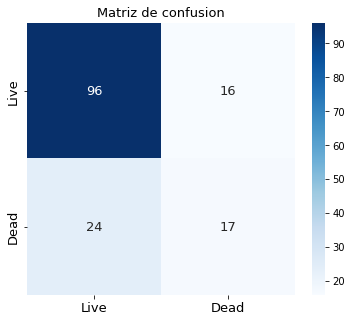

In [35]:
matrix = consufion_matrix(y_test, y_pred,'Dead', 'Live')

In [36]:
metricas(y_test, y_pred, matrix, label_title='probabilidad de morir en 5 años')

Accuracy  :   0.738562091503268
Kappa     :   0.2896935933147632
predicción probabilidad de morir en 5 años
Precision:   0.5151515151515151
Recall    :   0.4146341463414634
Specificity:   0.8571428571428571
F1-score   :   0.4594594594594595


- El modelo optimizado mejoro en la sensibilidad para la detección de casos con cancer, aunque la metrica no tiene un rendimiento alto para un caso tán critico como la detección de una enfermedad, ademas sigue teniendo un porcentaje de error tipo 2, demasiados falsos negativos.

In [37]:
pos_prob = model_final.predict_proba(X_test)

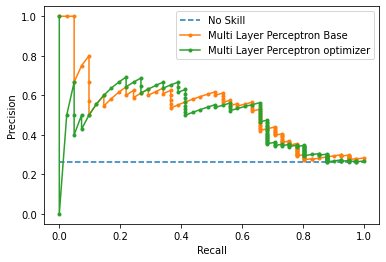

In [38]:
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = metrics.precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron Base')
auc_score_normal = metrics.auc(recall, precision)
precision, recall, _ = metrics.precision_recall_curve(y_test, pos_prob[:,1])
plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron optimizer')
auc_score_optimizer = metrics.auc(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [39]:
print('Multi Layer Perceptron Normal PR AUC: %.3f' % auc_score_normal)
print('Multi Layer Perceptron Optimizer PR AUC: %.3f' % auc_score_optimizer)

Multi Layer Perceptron Normal PR AUC: 0.524
Multi Layer Perceptron Optimizer PR AUC: 0.483


- El modelo `optimizado` no tiene un rendimiento deseado, incluso tiene uno pero que el modelo `base`, ya que no logra tener una compensasión ideal entre la precisión y el recall. La causa pueden ser muchas, más falta de datos, una estructura ineficiente, puede que las redes neuronales no sean un modelo indicado, más experimentos en la optimización de parametros, entre otros.

